In [1]:
import os
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
import av
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import VivitForVideoClassification, VivitImageProcessor, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load and split the data
df = pd.read_csv('E:/SRC-Bhuvaneswari/processed files/video/ftest/test_data.csv')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Save split datasets
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
TRAIN_CSV_PATH = 'train_data.csv'
TEST_CSV_PATH = 'test_data.csv'
SAVE_DIR = 'F:/SRC_Bhuvaneswari/typpo/Crimenet/VisTra/Checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)

# Define label mapping
LABEL_MAP = {'Normal': 0, 'Explosion': 1, 'Fighting': 2, 'Car Accident': 3, 'Shooting': 4, 'Riot': 5}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
NUM_CLASSES = len(LABEL_MAP)

# Define maximum clips per label - adjusted for full frame usage
MAX_TRAIN_SAMPLES = 110
MAX_TEST_SAMPLES = 30

# Define maximum frames per label for 80-20 ratio
# For a 80-20 ratio, if we assume each label should have equal representation
MAX_FRAME = 40000  # 80% of frames per label
MAX_TEST_FRAME = 10000  # 20% of frames per label

# Improved hyperparameters
LEARNING_RATE = 8.538808556803076e-05
TRAIN_BATCH_SIZE = 3  # Reduced to handle more frames
EVAL_BATCH_SIZE = 3
SEED = 24
GRADIENT_ACCUMULATION_STEPS = 8  # Increased for stability
NUM_EPOCHS = 10
CLIP_LEN = 32
FRAME_SAMPLE_RATE = 1  # Changed to 1 to use all frames
TARGET_FRAMES = 128

# Set random seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def load_data_from_csv(csv_path, video_path_column='rgb_video_path'):
    """Load and clean dataframe from CSV."""
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=[video_path_column, 'label'])
    return df

df_train = load_data_from_csv(TRAIN_CSV_PATH)
df_test = load_data_from_csv(TEST_CSV_PATH)

def balance_dataset(df, max_samples):
    """Balance dataset to have equal number of samples per class."""
    return df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), max_samples), random_state=SEED)
    )

df_train = balance_dataset(df_train, MAX_TRAIN_SAMPLES)
df_test = balance_dataset(df_test, MAX_TEST_SAMPLES)

# Function to balance test and train sets based on frame count
def balance_test_and_train_sets(df_train, df_test):
    """Balance test set to MAX_TEST_FRAME per label and move excess to training."""
    # Group test videos by label
    test_videos_by_label = {label: [] for label in LABEL_MAP.values()}
    test_frames_by_label = {label: 0 for label in LABEL_MAP.values()}
    
    # Count frames per label in test set
    for _, row in df_test.iterrows():
        video_path = row['rgb_video_path']
        label = int(row['label'])
        
        try:
            container = av.open(video_path)
            frame_count = container.streams.video[0].frames
            container.close()
            
            test_videos_by_label[label].append((video_path, frame_count))
            test_frames_by_label[label] += frame_count
        except Exception as e:
            print(f"Error processing test video {video_path}: {e}")
    
    # Move excess videos from test to train
    videos_to_move = []
    
    for label, videos in test_videos_by_label.items():
        if test_frames_by_label[label] > MAX_TEST_FRAME:
            # Sort videos by frame count (optional - depends on your strategy)
            videos.sort(key=lambda x: x[1])
            
            current_frames = 0
            keep_idx = 0
            
            # Find how many videos to keep in test set
            for i, (_, frame_count) in enumerate(videos):
                if current_frames + frame_count <= MAX_TEST_FRAME:
                    current_frames += frame_count
                    keep_idx = i + 1
                else:
                    break
            
            # Identify videos to move to training
            videos_to_move.extend([path for path, _ in videos[keep_idx:]])
            
            print(f"Label {INV_LABEL_MAP[label]}: Moving {len(videos) - keep_idx} videos " 
                  f"({test_frames_by_label[label] - current_frames} frames) from test to train")
            
            # Update frame count
            test_frames_by_label[label] = current_frames
    
    # Create masks for videos to keep in test and move to train
    keep_mask = ~df_test['rgb_video_path'].isin(videos_to_move)
    
    # Extract videos to move
    df_to_move = df_test[~keep_mask].copy()
    
    # Update test dataframe
    df_test_balanced = df_test[keep_mask].copy()
    
    # Add moved videos to training
    df_train_updated = pd.concat([df_train, df_to_move], ignore_index=True)
    
    print("\nUpdated frame distribution:")
    for label, frames in test_frames_by_label.items():
        print(f"Label {INV_LABEL_MAP[label]}: {frames} frames in test set")
    
    return df_train_updated, df_test_balanced

# Apply the balancing function
df_train, df_test = balance_test_and_train_sets(df_train, df_test)

# Print dataset statistics
print("\nBalanced number of videos per label in the training set:")
train_label_counts = df_train['label'].value_counts().sort_index().to_dict()
for label_id, count in train_label_counts.items():
    print(f"{INV_LABEL_MAP[label_id]} ({label_id}): {count} videos")

print("\nBalanced number of videos per label in the validation set:")
val_label_counts = df_test['label'].value_counts().sort_index().to_dict()
for label_id, count in val_label_counts.items():
    print(f"{INV_LABEL_MAP[label_id]} ({label_id}): {count} videos")

Label Fighting: Moving 4 videos (5760 frames) from test to train
Label Riot: Moving 13 videos (18300 frames) from test to train

Updated frame distribution:
Label Normal: 9384 frames in test set
Label Explosion: 8604 frames in test set
Label Fighting: 9841 frames in test set
Label Car Accident: 3861 frames in test set
Label Shooting: 4422 frames in test set
Label Riot: 8920 frames in test set

Balanced number of videos per label in the training set:
Normal (0): 110 videos
Explosion (1): 106 videos
Fighting (2): 114 videos
Car Accident (3): 110 videos
Shooting (4): 110 videos
Riot (5): 123 videos

Balanced number of videos per label in the validation set:
Normal (0): 30 videos
Explosion (1): 27 videos
Fighting (2): 26 videos
Car Accident (3): 30 videos
Shooting (4): 30 videos
Riot (5): 17 videos


C:\Users\admin\AppData\Local\Temp\ipykernel_6312\1990168452.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('label', group_keys=False).apply(
C:\Users\admin\AppData\Local\Temp\ipykernel_6312\1990168452.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('label', group_keys=False).apply(


In [2]:
# Analyze frame distribution
def analyze_frame_distribution():
    """Analyze frame distribution across labels to understand dataset imbalance."""
    label_frame_counts = {}
    label_video_counts = {}
    problematic_videos = []
    
    for _, row in df_train.iterrows():
        video_path = row['flow_video_path']
        label = row['label']
        
        try:
            container = av.open(video_path)
            total_frames = container.streams.video[0].frames
            container.close()
            
            if label not in label_frame_counts:
                label_frame_counts[label] = 0
                label_video_counts[label] = 0
                
            label_frame_counts[label] += total_frames
            label_video_counts[label] += 1
            
        except Exception as e:
            problematic_videos.append((video_path, str(e)))
            print(f"Error processing video {video_path}: {e}")
    
    # Print results
    print("Total frames per label in training set:")
    for label, count in label_frame_counts.items():
        label_name = INV_LABEL_MAP[label] if label in INV_LABEL_MAP else label
        avg_frames = count / label_video_counts[label] if label_video_counts[label] > 0 else 0
        print(f"{label_name}: {count} frames across {label_video_counts[label]} videos (avg: {avg_frames:.2f} frames/video)")
    
    results_df = pd.DataFrame({
        'Label': [INV_LABEL_MAP[label] if label in INV_LABEL_MAP else label for label in label_frame_counts.keys()],
        'Total Frames': label_frame_counts.values(),
        'Video Count': [label_video_counts[label] for label in label_frame_counts.keys()],
        'Avg Frames/Video': [label_frame_counts[label]/label_video_counts[label] 
                             if label_video_counts[label] > 0 else 0 
                             for label in label_frame_counts.keys()]
    })
    
    print("\nDataFrame of training results:")
    print(results_df)
    
    # Now analyze test set
    label_frame_counts_test = {}
    label_video_counts_test = {}
    
    for _, row in df_test.iterrows():
        video_path = row['flow_video_path']
        label = row['label']
        
        try:
            container = av.open(video_path)
            total_frames = container.streams.video[0].frames
            container.close()
            
            if label not in label_frame_counts_test:
                label_frame_counts_test[label] = 0
                label_video_counts_test[label] = 0
                
            label_frame_counts_test[label] += total_frames
            label_video_counts_test[label] += 1
            
        except Exception as e:
            print(f"Error processing test video {video_path}: {e}")
    
    print("\nTotal frames per label in test set:")
    for label, count in label_frame_counts_test.items():
        label_name = INV_LABEL_MAP[label] if label in INV_LABEL_MAP else label
        avg_frames = count / label_video_counts_test[label] if label_video_counts_test[label] > 0 else 0
        print(f"{label_name}: {count} frames across {label_video_counts_test[label]} videos (avg: {avg_frames:.2f} frames/video)")
    
    results_df_test = pd.DataFrame({
        'Label': [INV_LABEL_MAP[label] if label in INV_LABEL_MAP else label for label in label_frame_counts_test.keys()],
        'Total Frames': label_frame_counts_test.values(),
        'Video Count': [label_video_counts_test[label] for label in label_frame_counts_test.keys()],
        'Avg Frames/Video': [label_frame_counts_test[label]/label_video_counts_test[label] 
                             if label_video_counts_test[label] > 0 else 0 
                             for label in label_frame_counts_test.keys()]
    })
    
    print("\nDataFrame of test results:")
    print(results_df_test)
    
    # Calculate total frames and ratio
    total_train_frames = sum(label_frame_counts.values())
    total_test_frames = sum(label_frame_counts_test.values())
    total_frames = total_train_frames + total_test_frames
    
    print(f"\nTotal frames - Train: {total_train_frames}, Test: {total_test_frames}")
    print(f"Train-Test ratio: {total_train_frames/total_frames:.2f}:{total_test_frames/total_frames:.2f}")
    
    if problematic_videos:
        print(f"\nFound {len(problematic_videos)} problematic videos. Check logs for details.")
        with open("problematic_videos.log", "w") as f:
            for path, error in problematic_videos:
                f.write(f"{path}: {error}\n")
    
    return label_frame_counts, label_video_counts

# Run frame distribution analysis
label_frame_counts, label_video_counts = analyze_frame_distribution()

Total frames per label in training set:
Normal: 28988 frames across 110 videos (avg: 263.53 frames/video)
Explosion: 29586 frames across 106 videos (avg: 279.11 frames/video)
Fighting: 57256 frames across 114 videos (avg: 502.25 frames/video)
Car Accident: 15132 frames across 110 videos (avg: 137.56 frames/video)
Shooting: 22851 frames across 110 videos (avg: 207.74 frames/video)
Riot: 126027 frames across 123 videos (avg: 1024.61 frames/video)

DataFrame of training results:
          Label  Total Frames  Video Count  Avg Frames/Video
0        Normal         28988          110        263.527273
1     Explosion         29586          106        279.113208
2      Fighting         57256          114        502.245614
3  Car Accident         15132          110        137.563636
4      Shooting         22851          110        207.736364
5          Riot        126027          123       1024.609756

Total frames per label in test set:
Normal: 9384 frames across 30 videos (avg: 312.80 frame

In [3]:
# Enhanced data augmentation with strong augmentation option
def read_video_pyav(container, indices, is_training=True, strong_augment=False):
    """Read video frames with appropriate augmentation."""
    if is_training:
        if strong_augment:
            # Stronger augmentation for underrepresented classes
            transform = T.Compose([
                T.RandomResizedCrop(224, scale=(0.7, 1.0)),
                T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                T.RandomRotation(30),
                T.RandomHorizontalFlip(p=0.7),
                T.RandomVerticalFlip(p=0.3),
                T.RandomGrayscale(p=0.2),
                T.ToTensor()
            ])
        else:
            # Regular augmentation
            transform = T.Compose([
                T.RandomResizedCrop(224, scale=(0.8, 1.0)),
                T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                T.RandomRotation(15),
                T.RandomHorizontalFlip(p=0.5),
                T.ToTensor()
            ])
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor()
        ])

    frames = []
    container.seek(0)
    try:
        for i, frame in enumerate(container.decode(video=0)):
            if i in indices:
                frame = transform(frame.to_image())
                frames.append(frame)
            if len(frames) == len(indices):
                break
    except Exception as e:
        print(f"Error during frame decoding: {e}")
        return None

    if not frames:
        return None
        
    return torch.stack(frames)

def split_into_chunks(total_frames, clip_len, overlap=0):
    """Split video into overlapping chunks."""
    step = clip_len - overlap
    chunks = [(start, start + clip_len) for start in range(0, total_frames, step) if start + clip_len <= total_frames]
    return chunks

class VideoDataset(Dataset):
    def __init__(self, dataframe, processor, clip_len=32, frame_sample_rate=1, 
                 target_frames=128, overlap=0, is_training=True, video_path_column='flow_video_path',
                 max_frames_per_label=MAX_FRAME):
        self.dataframe = dataframe
        self.processor = processor
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.target_frames = target_frames
        self.overlap = overlap
        self.is_training = is_training
        self.video_path_column = video_path_column
        self.max_frames_per_label = max_frames_per_label
        self.problematic_files = []  # Initialize before calling _prepare_data
        self.data = self._prepare_data()
        
    def _prepare_data(self):
        """Prepare dataset by processing videos into clips."""
        prepared_data = []
        short_clips = []
        
        for _, row in self.dataframe.iterrows():
            video_path = row[self.video_path_column]
            label = int(row['label'])
            try:
                container = av.open(video_path)
                total_frames = container.streams.video[0].frames
                container.close()
                
                if total_frames >= self.clip_len * self.frame_sample_rate:
                    chunks = split_into_chunks(total_frames, self.clip_len * self.frame_sample_rate, self.overlap)
                    for start, end in chunks:
                        prepared_data.append({
                            "video_path": video_path, 
                            "label": label, 
                            "start": start, 
                            "end": end,
                            "combined": False
                        })
                else:
                    short_clips.append({
                        "video_path": video_path,
                        "label": label,
                        "frames": total_frames,
                        "combined": True
                    })
            except Exception as e:
                self.problematic_files.append((video_path, str(e)))
                print(f"Error processing video {video_path}: {e}")
        
        # Log problematic files
        if self.problematic_files:
            log_path = "problematic_files_dataset.log"
            with open(log_path, "w") as f:
                for path, error in self.problematic_files:
                    f.write(f"{path}: {error}\n")
            print(f"Logged {len(self.problematic_files)} problematic files to {log_path}")
        
        combined_clips = self._combine_short_clips(short_clips)
        prepared_data.extend(combined_clips)
        
        # Balance clips by frame count
        if self.is_training:
            prepared_data = self._balance_clips_by_label(prepared_data)
        
        print(f"\nTotal clips: {len(prepared_data)}, including {len(combined_clips)} combined clips")
        print(f"Combined clips processing summary: {len(combined_clips)} clips created from {len(short_clips)} short clips, {len(short_clips) - sum([len(clip['video_paths']) for clip in combined_clips])} clips discarded.")

        return prepared_data
    
    def _balance_clips_by_label(self, clips):
        """Balance clips to ensure each label has max_frames_per_label frames."""
        label_groups = {}
        label_frame_counts = {}
    
        # Calculate frame counts per clip and per label
        for clip in clips:
            label = clip["label"]
            if label not in label_groups:
                label_groups[label] = []
                label_frame_counts[label] = 0
            
            # Calculate actual frame count for this clip
            if not clip.get("combined", False):
                frame_count = (clip["end"] - clip["start"]) // self.frame_sample_rate
            else:
                frame_count = sum(clip.get("frames_per_clip", [0])) // self.frame_sample_rate
            
            clip['frame_count'] = frame_count  # Store frame count directly in clip
            label_groups[label].append(clip)
            label_frame_counts[label] += frame_count
    
        balanced_clips = []
    
        for label, label_clips in label_groups.items():
            current_frames = label_frame_counts[label]
            
            if current_frames > self.max_frames_per_label:
                # Downsample strategy: keep largest clips first
                sorted_clips = sorted(label_clips, key=lambda x: x['frame_count'], reverse=True)
                accumulated = 0
                selected_clips = []
                
                for clip in sorted_clips:
                    if accumulated + clip['frame_count'] <= self.max_frames_per_label:
                        selected_clips.append(clip)
                        accumulated += clip['frame_count']
                    elif accumulated == 0:  # Handle case where single clip exceeds max
                        selected_clips.append(clip)
                        accumulated += clip['frame_count']
                        break
                
                balanced_clips.extend(selected_clips)
                print(f"Label {INV_LABEL_MAP[label]} ({label}): "
                      f"Reduced from {current_frames} to {accumulated} frames")
    
            else:
                # Upsample strategy: augment until reaching max_frames_per_label
                balanced_clips.extend(label_clips)
                accumulated = current_frames
                deficit = self.max_frames_per_label - accumulated
                
                if deficit > 0:
                    original_clips = label_clips.copy()
                    while deficit > 0:
                        for clip in original_clips:
                            if deficit <= 0:
                                break
                                
                            augmented_clip = clip.copy()
                            augmented_clip["augment_strongly"] = True
                            balanced_clips.append(augmented_clip)
                            deficit -= clip['frame_count']
                            accumulated += clip['frame_count']
    
                    print(f"Label {INV_LABEL_MAP[label]} ({label}): "
                          f"Increased from {current_frames} to {accumulated - deficit} frames "
                          f"(added {len(balanced_clips) - len(label_clips)} augmented clips)")
        
        # Verification step to confirm balancing
        final_label_frames = {}
        for clip in balanced_clips:
            label = clip["label"]
            if label not in final_label_frames:
                final_label_frames[label] = 0
            final_label_frames[label] += clip['frame_count']
        
        print("\nFinal frame count per label after balancing:")
        for label, count in final_label_frames.items():
            print(f"Label {INV_LABEL_MAP[label]} ({label}): {count} frames")
    
        return balanced_clips

    
    def _combine_short_clips(self, short_clips):
        """Combine short clips to reach minimum length."""
        label_groups = {}
        for clip in short_clips:
            label = clip["label"]
            if label not in label_groups:
                label_groups[label] = []
            label_groups[label].append(clip)
        
        combined_data = []
        for label, clips in label_groups.items():
            current_clips = []
            current_frames = 0
            
            for clip in clips:
                if current_frames + clip["frames"] <= self.target_frames:
                    current_clips.append(clip)
                    current_frames += clip["frames"]
                    
                    if current_frames >= self.clip_len * self.frame_sample_rate:
                        combined_data.append({
                            "video_paths": [c["video_path"] for c in current_clips],
                            "label": label,
                            "frames_per_clip": [c["frames"] for c in current_clips],
                            "combined": True
                        })
                        current_clips = []
                        current_frames = 0
            
            if current_clips and current_frames >= self.clip_len * self.frame_sample_rate:
                combined_data.append({
                    "video_paths": [c["video_path"] for c in current_clips],
                    "label": label,
                    "frames_per_clip": [c["frames"] for c in current_clips],
                    "combined": True
                })
        
        return combined_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        strong_augment = item.get("augment_strongly", False)
        
        if not item.get("combined", False):
            video_path, label, start, end = item["video_path"], item["label"], item["start"], item["end"]
            try:
                container = av.open(video_path)
                indices = list(range(start, end, self.frame_sample_rate))
                if len(indices) != self.clip_len:
                    container.close()
                    return None
                    
                video = read_video_pyav(container, indices, self.is_training, strong_augment)
                container.close()
                
                if video is None:
                    return None
                
                # Check if frames are valid
                if torch.isnan(video).any() or torch.isinf(video).any():
                    print(f"Invalid frame values detected in {video_path}")
                    return None
                
                # Add temporal dropout for additional augmentation when training
                if self.is_training and np.random.random() < 0.3:
                    # Randomly drop up to 10% of frames and repeat adjacent frames
                    num_frames_to_drop = max(1, int(0.1 * video.shape[0]))
                    frames_to_drop = np.random.choice(video.shape[0], num_frames_to_drop, replace=False)
                    for idx in frames_to_drop:
                        # Replace with previous or next frame
                        replace_idx = max(0, idx-1) if idx > 0 else min(idx+1, video.shape[0]-1)
                        video[idx] = video[replace_idx]
                
                inputs = self.processor(list(video.permute(0, 2, 3, 1).numpy()), return_tensors="pt")
                return {"pixel_values": inputs["pixel_values"].squeeze(0), "labels": torch.tensor(label, dtype=torch.long)}
            except Exception as e:
                print(f"Error loading video chunk from {video_path}: {e}")
                self.problematic_files.append((video_path, str(e)))
                return None
        
        else:
            video_paths = item["video_paths"]
            frames_per_clip = item["frames_per_clip"]
            label = item["label"]
            
            all_frames = []
            current_frame_count = 0
            
            for i, video_path in enumerate(video_paths):
                try:
                    container = av.open(video_path)
                    frames_needed = min(frames_per_clip[i], self.clip_len * self.frame_sample_rate - current_frame_count)
                    indices = list(range(0, frames_needed))
                    video = read_video_pyav(container, indices, self.is_training, strong_augment)
                    container.close()
                    
                    if video is None:
                        continue
                    
                    # Check if frames are valid
                    if torch.isnan(video).any() or torch.isinf(video).any():
                        print(f"Invalid frame values detected in {video_path}")
                        continue
                        
                    all_frames.append(video)
                    current_frame_count += frames_needed
                    
                    if current_frame_count >= self.clip_len * self.frame_sample_rate:
                        break
                except Exception as e:
                    print(f"Error loading combined video from {video_path}: {e}")
                    self.problematic_files.append((video_path, str(e)))
            
            if not all_frames or current_frame_count < self.clip_len * self.frame_sample_rate:
                return None
                
            combined_video = torch.cat(all_frames, dim=0)
            
            if combined_video.shape[0] > self.clip_len:
                combined_video = combined_video[:self.clip_len]
                
            inputs = self.processor(list(combined_video.permute(0, 2, 3, 1).numpy()), return_tensors="pt")
            return {"pixel_values": inputs["pixel_values"].squeeze(0), "labels": torch.tensor(label, dtype=torch.long)}

In [4]:
def collate_fn(batch):
    """Custom collate function that handles None values in batch."""
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Fixed rescaling issue
processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2", do_rescale=None, offset=None)
model = VivitForVideoClassification.from_pretrained(
    "google/vivit-b-16x2",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True,
    hidden_dropout_prob=0.1,  # Reduced from 0.2
    attention_probs_dropout_prob=0.1  # Reduced from 0.2
)

# Initialize datasets and dataloaders with different max frames for train and test
train_dataset = VideoDataset(df_train, processor, CLIP_LEN, FRAME_SAMPLE_RATE, 
                            target_frames=TARGET_FRAMES, overlap=16, is_training=True,
                            max_frames_per_label=MAX_FRAME)
test_dataset = VideoDataset(df_test, processor, CLIP_LEN, FRAME_SAMPLE_RATE, 
                           target_frames=TARGET_FRAMES, overlap=16, is_training=False,
                           max_frames_per_label=MAX_TEST_FRAME)
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                             shuffle=True, collate_fn=collate_fn, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, 
                            shuffle=False, collate_fn=collate_fn, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Switch optimizer and adjust weight decay
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=1e-6  # Reduced from 1e-5
)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
num_warmup_steps = int(num_training_steps * 0.1)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Calculate class weights for loss function
train_labels = df_train["label"].values
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use label smoothing for better generalization
loss_fn = CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

scaler = GradScaler()
best_val_accuracy = 0

Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Label Normal (0): Reduced from 53041 to 39985 frames
Label Explosion (1): Reduced from 54426 to 39994 frames
Label Fighting (2): Reduced from 109427 to 39987 frames
Label Car Accident (3): Increased from 25293 to 40026 frames (added 4205 augmented clips)
Label Shooting (4): Reduced from 40820 to 39988 frames
Label Riot (5): Reduced from 247072 to 40000 frames

Final frame count per label after balancing:
Label Normal (0): 39985 frames
Label Explosion (1): 39994 frames
Label Fighting (2): 39987 frames
Label Car Accident (3): 40013 frames
Label Shooting (4): 39988 frames
Label Riot (5): 40000 frames

Total clips: 7489, including 19 combined clips
Combined clips processing summary: 19 clips created from 42 short clips, 3 clips discarded.

Total clips: 2585, including 3 combined clips
Combined clips processing summary: 3 clips created from 8 short clips, 1 clips discarded.


C:\Users\admin\AppData\Local\Temp\ipykernel_6312\606823178.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [5]:
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    epoch_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}", leave=True)
    for step, batch in enumerate(epoch_progress_bar):
        if batch is None:
            continue

        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.amp.autocast('cuda'):
            outputs = model(pixel_values=batch["pixel_values"])
            loss = loss_fn(outputs.logits, batch["labels"]) / GRADIENT_ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            # Add this line to unscale gradients first
            scaler.unscale_(optimizer)
    
            # Add gradient clipping here
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

        epoch_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS

        epoch_progress_bar.set_postfix({
            "Loss": f"{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}",
            "Accuracy": f"{(correct_predictions / total_predictions) * 100:.2f}%"
        })

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    history["train_loss"].append(avg_epoch_loss)
    history["train_accuracy"].append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Validation"):
            if batch is None:
                continue
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(pixel_values=batch["pixel_values"], interpolate_pos_encoding=True)
            val_loss += loss_fn(outputs.logits, batch["labels"]).item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            val_correct_predictions += (predictions == batch["labels"]).sum().item()
            val_total_predictions += batch["labels"].size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = val_loss / len(test_dataloader)
    val_accuracy = val_correct_predictions / val_total_predictions
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_accuracy)

    # Save best model based on accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_model_acc.pt"))
        print(f"New best model saved with validation accuracy: {val_accuracy * 100:.2f}%")

    # Save model at each epoch
    torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"vivit_epoch_{epoch + 1}.pt"))

    print(f"Epoch {epoch + 1} completed. Train Loss: {avg_epoch_loss:.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy * 100:.2f}%")

    # Create confusion matrix every epoch
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(LABEL_MAP.keys()))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - Epoch {epoch + 1}")
    plt.savefig(os.path.join(SAVE_DIR, f'confusion_matrix_epoch_{epoch + 1}.png'))
    plt.close()

Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:08<00:00,  1.68s/it]


New best model saved with validation accuracy: 47.89%
Epoch 1 completed. Train Loss: 1.4454, Train Accuracy: 48.54%, Val Loss: 1.4029, Val Accuracy: 47.89%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:32<00:00,  1.71s/it]


New best model saved with validation accuracy: 51.64%
Epoch 2 completed. Train Loss: 0.7386, Train Accuracy: 86.67%, Val Loss: 1.3229, Val Accuracy: 51.64%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:22<00:00,  1.70s/it]


New best model saved with validation accuracy: 57.79%
Epoch 3 completed. Train Loss: 0.5577, Train Accuracy: 94.89%, Val Loss: 1.2561, Val Accuracy: 57.79%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:29<00:00,  1.71s/it]


Epoch 4 completed. Train Loss: 0.4902, Train Accuracy: 97.86%, Val Loss: 1.4120, Val Accuracy: 51.68%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:39<00:00,  1.72s/it]


New best model saved with validation accuracy: 58.88%
Epoch 5 completed. Train Loss: 0.4621, Train Accuracy: 98.80%, Val Loss: 1.3566, Val Accuracy: 58.88%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:05<00:00,  1.68s/it]


Epoch 6 completed. Train Loss: 0.4499, Train Accuracy: 99.13%, Val Loss: 1.3901, Val Accuracy: 54.00%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:22<00:00,  1.70s/it]


Epoch 7 completed. Train Loss: 0.4457, Train Accuracy: 99.16%, Val Loss: 1.4724, Val Accuracy: 57.06%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:05<00:00,  1.68s/it]


New best model saved with validation accuracy: 61.12%
Epoch 8 completed. Train Loss: 0.4486, Train Accuracy: 98.91%, Val Loss: 1.3897, Val Accuracy: 61.12%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:12<00:00,  1.69s/it]


Epoch 9 completed. Train Loss: 0.4428, Train Accuracy: 99.07%, Val Loss: 1.4553, Val Accuracy: 59.54%


Validation: 100%|████████████████████████████████████████████████████████████████████| 862/862 [24:24<00:00,  1.70s/it]


Epoch 10 completed. Train Loss: 0.4399, Train Accuracy: 99.27%, Val Loss: 1.7250, Val Accuracy: 53.00%


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Accuracy')

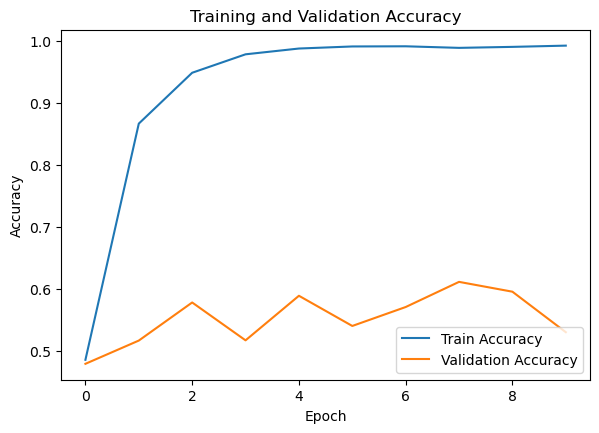

In [6]:
# Plot training and validation metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history["train_accuracy"wwwwwww], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

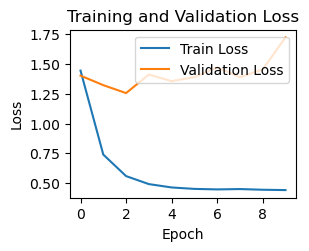

In [7]:
plt.subplot(2, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

In [8]:
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'training_metrics.png'))
plt.close()

In [9]:
print(f"Training completed.")

Training completed.
